에피폴라 지오메트리가 뭔지 몰라서  
  
https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html  

일단 독스를 쳐보기로 한다  

http://www.gisdeveloper.co.kr/?p=6922  

누군가의 번역본  

When we take an image using pin-hole camera, we loose an important information, ie depth of the image. Or how far is each point in the image from the camera because it is a 3D-to-2D conversion. So it is an important question whether we can find the depth information using these cameras. And the answer is to use more than one camera. Our eyes works in similar way where we use two cameras (two eyes) which is called stereo vision. So let's see what OpenCV provides in this field.  
  
  
카메라를 통해 이미지를 촬영할 때, 이미지의 깊이라는 중요한 정보가 소실됩니다. 달리 말해 3차원에서 2차원으로 변환되므로 카메라의 위치에서 이미지의 각 지점이 얼마나 멀리 떨어져 있는지 알 수 없습니다. 그래서 그래서 이러한 카메라를 이용하여 깊이 정보를 얻을 수 있는지에 대한 것은 중요한 문제입니다. 그리고 그에 대한 대답은 하나 이상의 카메라를 이용한다면 가능하다입니다. 우리의 두 눈은 2개의 카메라에 비유할 수 있는데, 이처럼 2대의 카메라를 이용한 Vison 영역을 스테레오 비전(Stero Vision)이라고 합니다. 스테레오 비전을 위해 OpenCV에서 제공하는 것은 무엇인지도 살펴 보겠습니다.  
  

In [13]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [14]:
img_1 = cv2.imread('cv2_hw/paired_images/bryce_01_left.png',0)  #queryimage # left image
img_2 = cv2.imread('cv2_hw/paired_images/bryce_01_right.png',0) #trainimage # right image

오늘 처음알았는데, 경로에 한글이름은 주피터에서 인식을 못하는 것 같더라

In [15]:
sift = cv2.SIFT_create()
#sift = cv2.xfeatures2d.SIFT_create() 3버전대 메서드 이름

#sift쓰기위해서 막 3버전대로 낮춰야 할꺼는 또 아녔나보네?

In [16]:
kp1, des1 = sift.detectAndCompute(img_1, None)
kp2, des2 = sift.detectAndCompute(img_2, None)

In [17]:
#FLANN parameters
#매쳐중에 FLANN이란애가 있나보다, 내가 수업을 안들었나보지 뭐
FLANN_INDEX_KDTREE = 1 # 이게 뭘까?
index_params = dict(algorithm = FLANN_INDEX_KDTREE, tress = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

In [18]:
pts1 = []
pts2 = []

#ratio test as per Lowe's paper #??????
for i, (m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
#이거 good matching 찾는 알고리즘인데

Now we have the list of best matches from both the images. Let's find the Fundamental Matrix.

In [19]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)

In [20]:
#we select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

Next we find the epilines. Epilines corresponding to the points in first image is drawn on second image.  
So mentioning of correct images are important here. We get an array of lines. So we define a new function to draw these lines on the images.

여기 아래부터가 중요한데,,,

In [21]:
def draw_lines(img_1, img_2, lines, pts1, pts2):
    r, c = img_1.shape
    img_1 = cv2.cvtColor(img_1, cv2.COLOR_GRAY2BGR)
    img_2 = cv2.cvtColor(img_2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0]*c) / r[1] ])
        img_1 = cv2.line(img_1, (x0, y0), (x1, y1), color, 1)
        img_1 = cv2.circle(img_1, tuple(pt1), 5, color, -1)
        img_2 = cv2.circle(img_2, tuple(pt2), 5, color, -1)
    return img_1, img_2

In [24]:
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5, img6 = draw_lines(img_1, img_2, lines1, pts1, pts2)

In [25]:
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3, img4 = draw_lines(img_2, img_1, lines2, pts2, pts1)

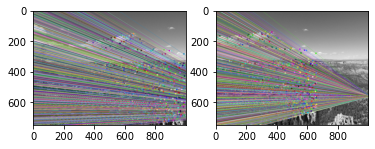

In [30]:
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()
#왜 서브플랏 121과 122 외에는 에러가 날까?